In [1]:
from multiprocessing import Pool,Process,Manager,cpu_count
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
from PIL import Image,ImageFilter
import warnings
import scipy.optimize as opt
import scipy as sp
import cmath
import time 
import math

%matplotlib inline
warnings.filterwarnings('ignore')

font = {'family' : 'Ubuntu',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)

from tabulate import tabulate as tb

In [2]:
def ListofFiles(path):
    filelist=[]
    for root, dirs, files in os.walk(path):
        for file in files:
             filelist.append(os.path.join(root,file))
    return filelist

def getImageValues(Files,EventLimit=1):
    if(type(Files) is list or type(Files) is np.ndarray):
        values={}
        count=0
        for file in Files:
            img1=Image.open(file)
            imgArray=np.array(img1)
            values[count]=imgArray
            count+=1
            if(EventLimit==count):
                break
        print(f" {count} frames in dictinary ")
    else:
        img1=Image.open(Files)
        values=np.array(img1)
    return values

def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data

def MaskCreate(pixel,radius,center,plot=False,sp="Circle"):
    XPixel,YPixel=pixel
    centerX,centerY=center
    x=np.arange(0,XPixel,1)
    y=np.arange(0,YPixel,1)
    xx,yy=np.meshgrid(x,y)
    rr=np.sqrt((xx-centerX)**2+(yy-centerY)**2)
    mask=0
    values=np.zeros(rr.shape)
    if(sp=="Rectangle"):
        rr[centerX-radius[0] :centerX+radius[0],centerY-radius[1] :centerY+radius[1]]=-1
        mask=rr==-1
        mask=mask.transpose()
    else:
        mask=rr<radius
        
    values[mask]=1       
    
    if(plot):
        plt.figure(figsize=(12,8),dpi=300)
        plt.title("Mask Position")
        plt.xlabel("PixelX")
        plt.ylabel("PixelY")
        plt.imshow(values,cmap="gray",origin="lower",vmin=values.min(),vmax=values.max())
        plt.show()
    
    return mask,values,[centerX,centerY]
    

In [3]:
Path="../data/10bar_7days_purified/Camera/CRAB_9_17_2023/17k_8k_7k/22ms/" #(For Slides)
#Path="/media/argon/Data/CRAB_NEW_II/data/6bar/22ms"
Images=getImageValues(ListofFiles(Path),20000)


 20000 frames in dictinary 


In [4]:
#Images=PickleITRead("NEWII_6Bar_20000_22ms.p")

In [5]:
PixelShape=(512,512)
OffsetY=0
OffsetX=0

Needle14cmMask=MaskCreate((PixelShape),50,(215+OffsetX,270+OffsetY))

Needle9cmMask=MaskCreate(PixelShape,50,(309+OffsetX,306+OffsetY))

Needle4cmMask=MaskCreate(PixelShape,50,(261+OffsetX,180+OffsetY))

In [63]:
## 10 Bar Old Image Intensifier

Values={"4cm":np.array([]),"9cm":np.array([]),"14cm":np.array([]),"4cm_cut":np.array([]),"9cm_cut":np.array([]),"14cm_cut":np.array([])}

Cut4cmImages={}
Cut9cmImages={}
Cut14cmImages={}

count=[0,0,0]
for i in Images:
    Values["4cm"]=np.append(Values["4cm"],np.mean(Images[i][Needle4cmMask[0]]))
    Values["9cm"]=np.append(Values["9cm"],np.mean(Images[i][Needle9cmMask[0]]))
    Values["14cm"]=np.append(Values["14cm"],np.mean(Images[i][Needle14cmMask[0]]))
    if(np.mean(Images[i][Needle4cmMask[0]])>2175 ):#and np.mean(Images[i][Needle9cmMask[0]])<2100 and np.mean(Images[i][Needle14cmMask[0]]) <2100):
        Cut4cmImages[count[0]]=Images[i]
        count[0]=count[0]+1
        
    if(np.mean(Images[i][Needle4cmMask[0]])<2100 and np.mean(Images[i][Needle9cmMask[0]])>2175 and np.mean(Images[i][Needle14cmMask[0]]) <2100):
        Cut9cmImages[count[1]]=Images[i]
        count[1]=count[1]+1
         
    if(np.mean(Images[i][Needle4cmMask[0]])<2100 and np.mean(Images[i][Needle9cmMask[0]])<2100 and np.mean(Images[i][Needle14cmMask[0]]) >2175):
        Cut14cmImages[count[2]]=Images[i]
        count[2]=count[2]+1


In [64]:
print(Cut14cmImages[0])

[[2091 2118 2116 ... 2079 2104 2103]
 [2105 2072 2077 ... 2079 2055 2096]
 [2085 2051 2070 ... 2086 2105 2100]
 ...
 [2054 2073 2027 ... 2031 1999 2053]
 [2056 2085 2018 ... 2046 1995 2015]
 [2077 2068 2045 ... 2059 2004 2017]]


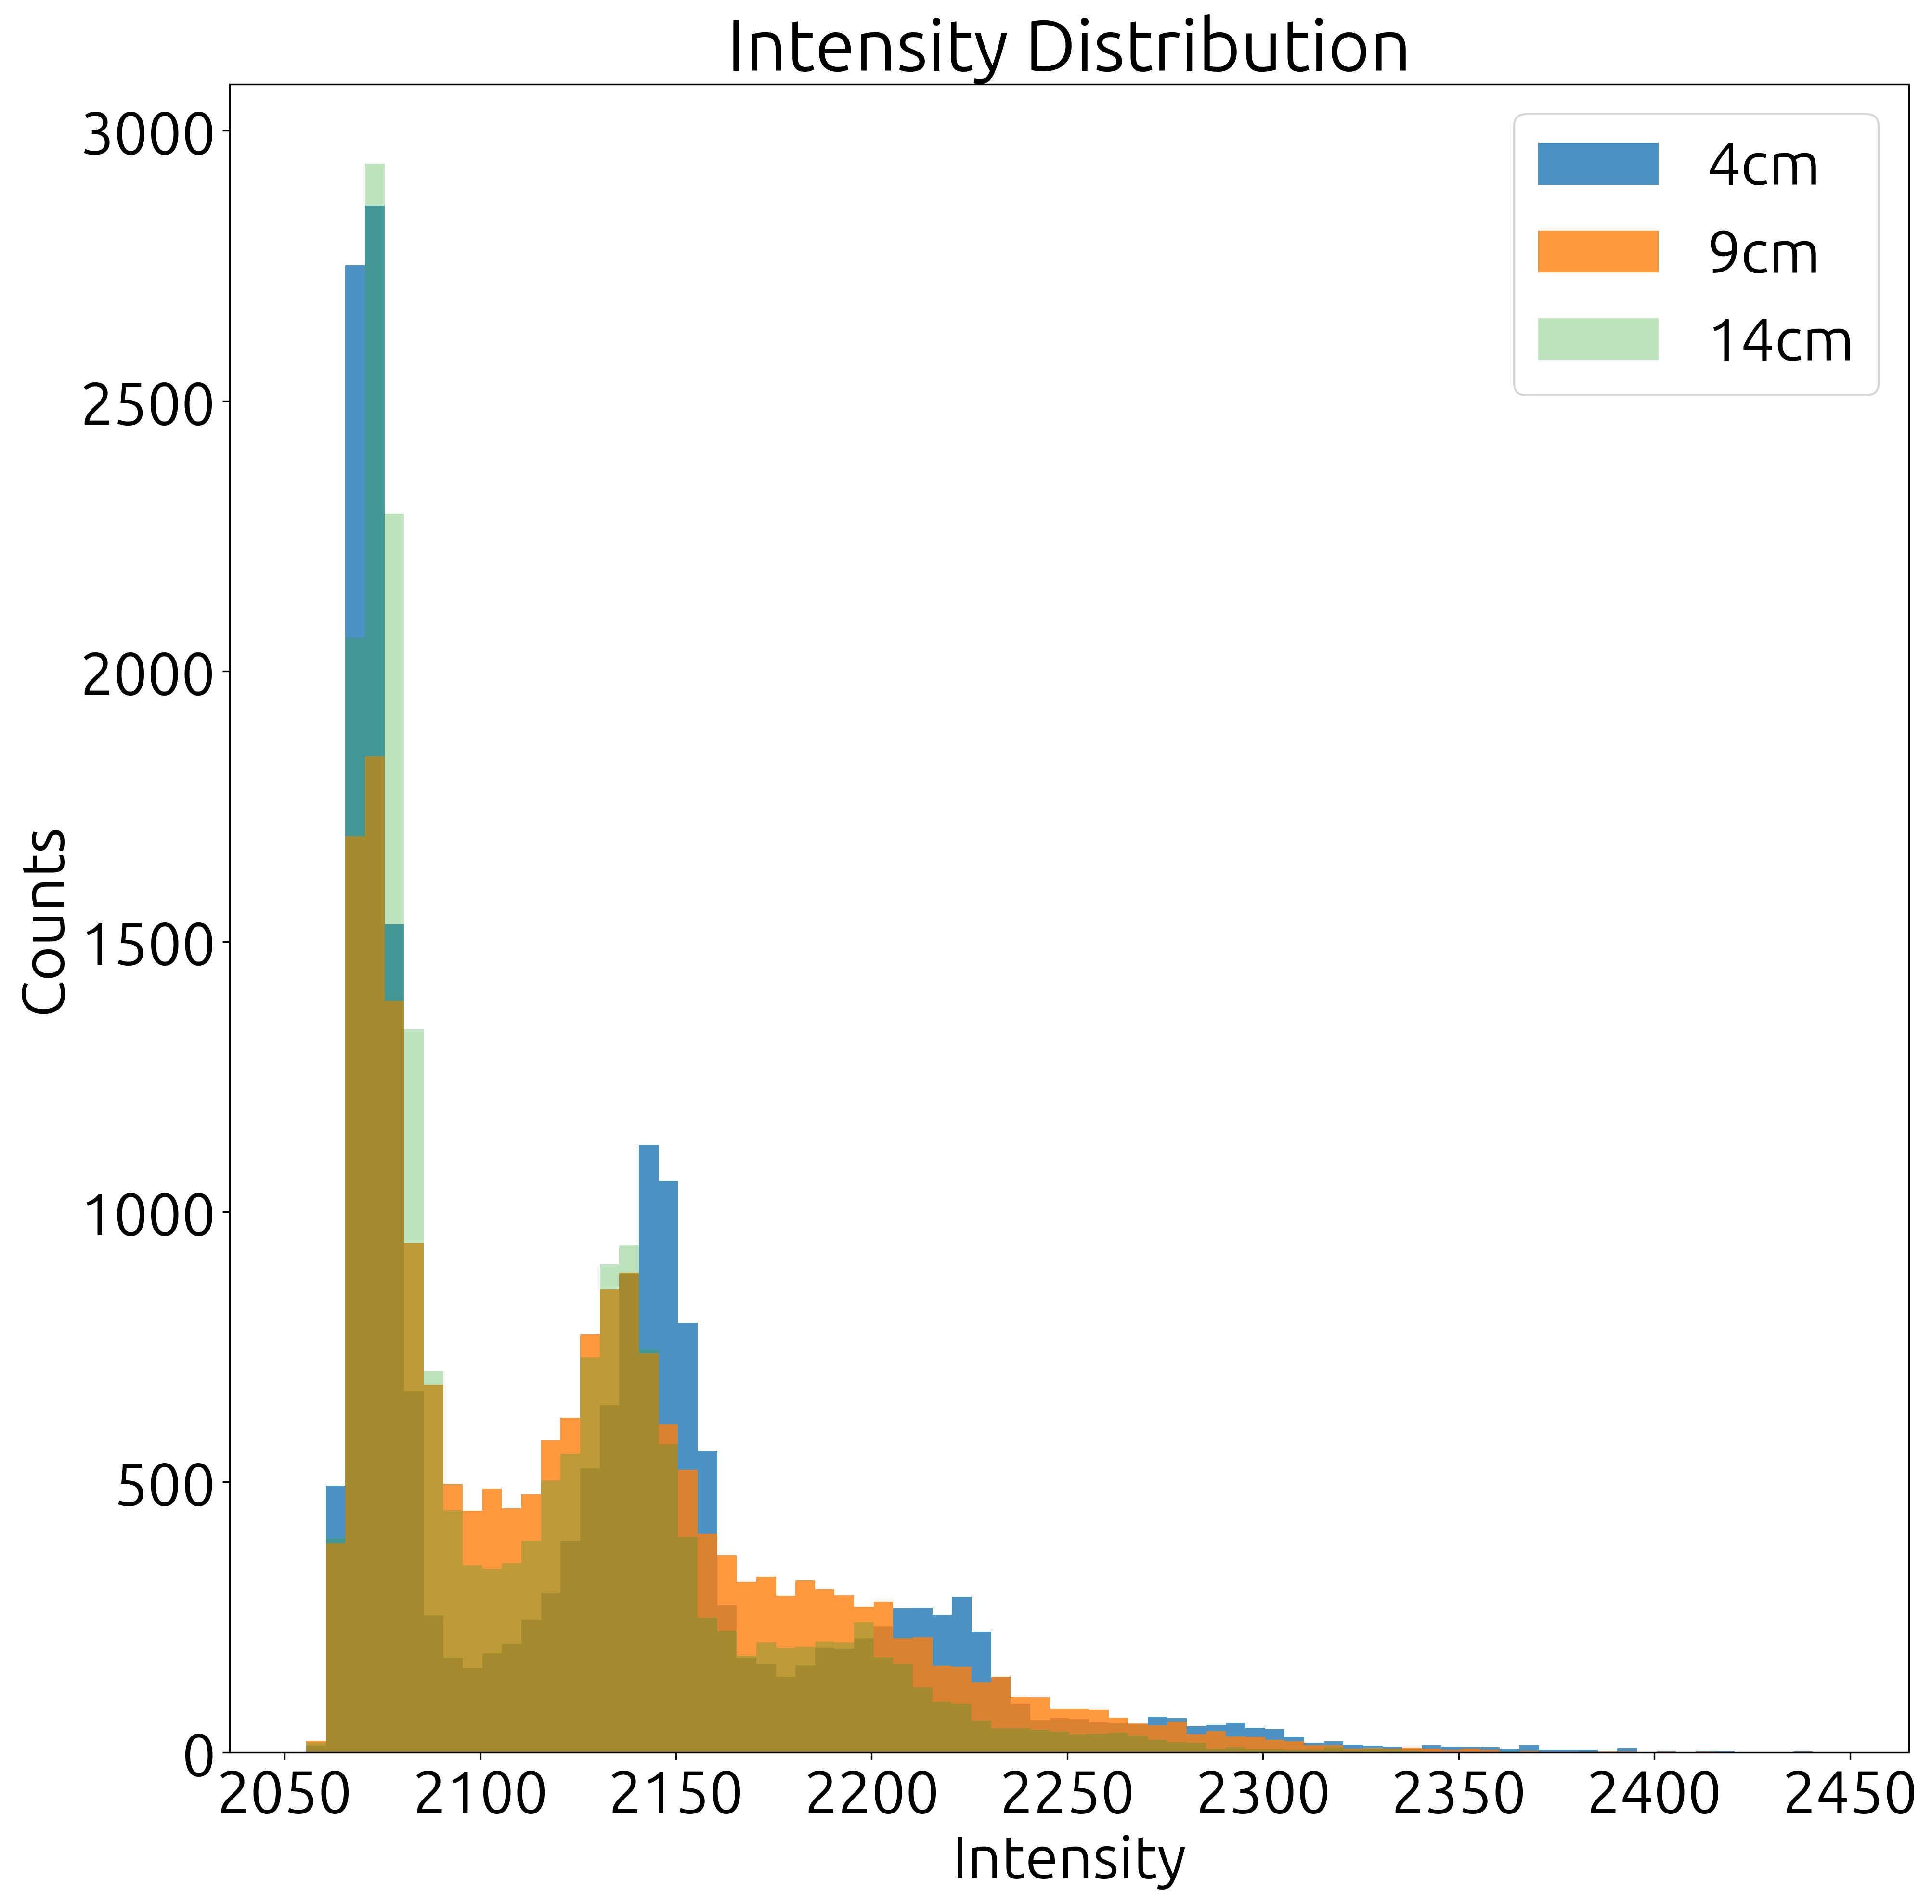

In [8]:
binss=np.arange(np.min(Values["14cm"]),np.max(Values["4cm"]),5)

plt.figure(figsize=(15,15),dpi=300)
plt.title("Intensity Distribution")
plt.hist(Values["4cm"],label="4cm",bins=binss,alpha=0.8)
plt.hist(Values["9cm"],label="9cm",bins=binss,alpha=0.8)
plt.hist(Values["14cm"],label="14cm",bins=binss,alpha=0.3)
#plt.vlines(2150,0,1200)
plt.xlabel("Intensity")
plt.ylabel("Counts")
plt.legend()
plt.show()

In [9]:
## Average the images
def AvergImage(II,rangex,Single=True,start=0):
    img=np.zeros(II[0].shape)
    if (rangex>len(II.keys())):
        rangex=len(II.keys())
    # Average only one set
    if(Single):
        for i in range(start,rangex+start):
            img+=II[i]
        img=img/rangex
        return img
    else: # Average Multiple Sets of Images
        cnt=0
        fImages=[]
        while(cnt<=len(II.keys())-1):
            img+=II[cnt]
            if (cnt%(rangex)==0 and cnt>0):
                fImages.append(img/rangex)
                img=np.zeros(II[0].shape)
            cnt=cnt+1
        return fImages
    

In [10]:
AveragedImages=AvergImage(Images,200,Single=False)

In [11]:
print(f"Amount of Images is {len(AveragedImages)}")

Amount of Images is 99


In [12]:
ValuesA={"4cm":np.array([]),"9cm":np.array([]),"14cm":np.array([])}

for i in AveragedImages:
    ValuesA["4cm"]=np.append(ValuesA["4cm"],np.mean(i[Needle4cmMask[0]]))
    ValuesA["9cm"]=np.append(ValuesA["9cm"],np.mean(i[Needle9cmMask[0]]))
    ValuesA["14cm"]=np.append(ValuesA["14cm"],np.mean(i[Needle14cmMask[0]]))


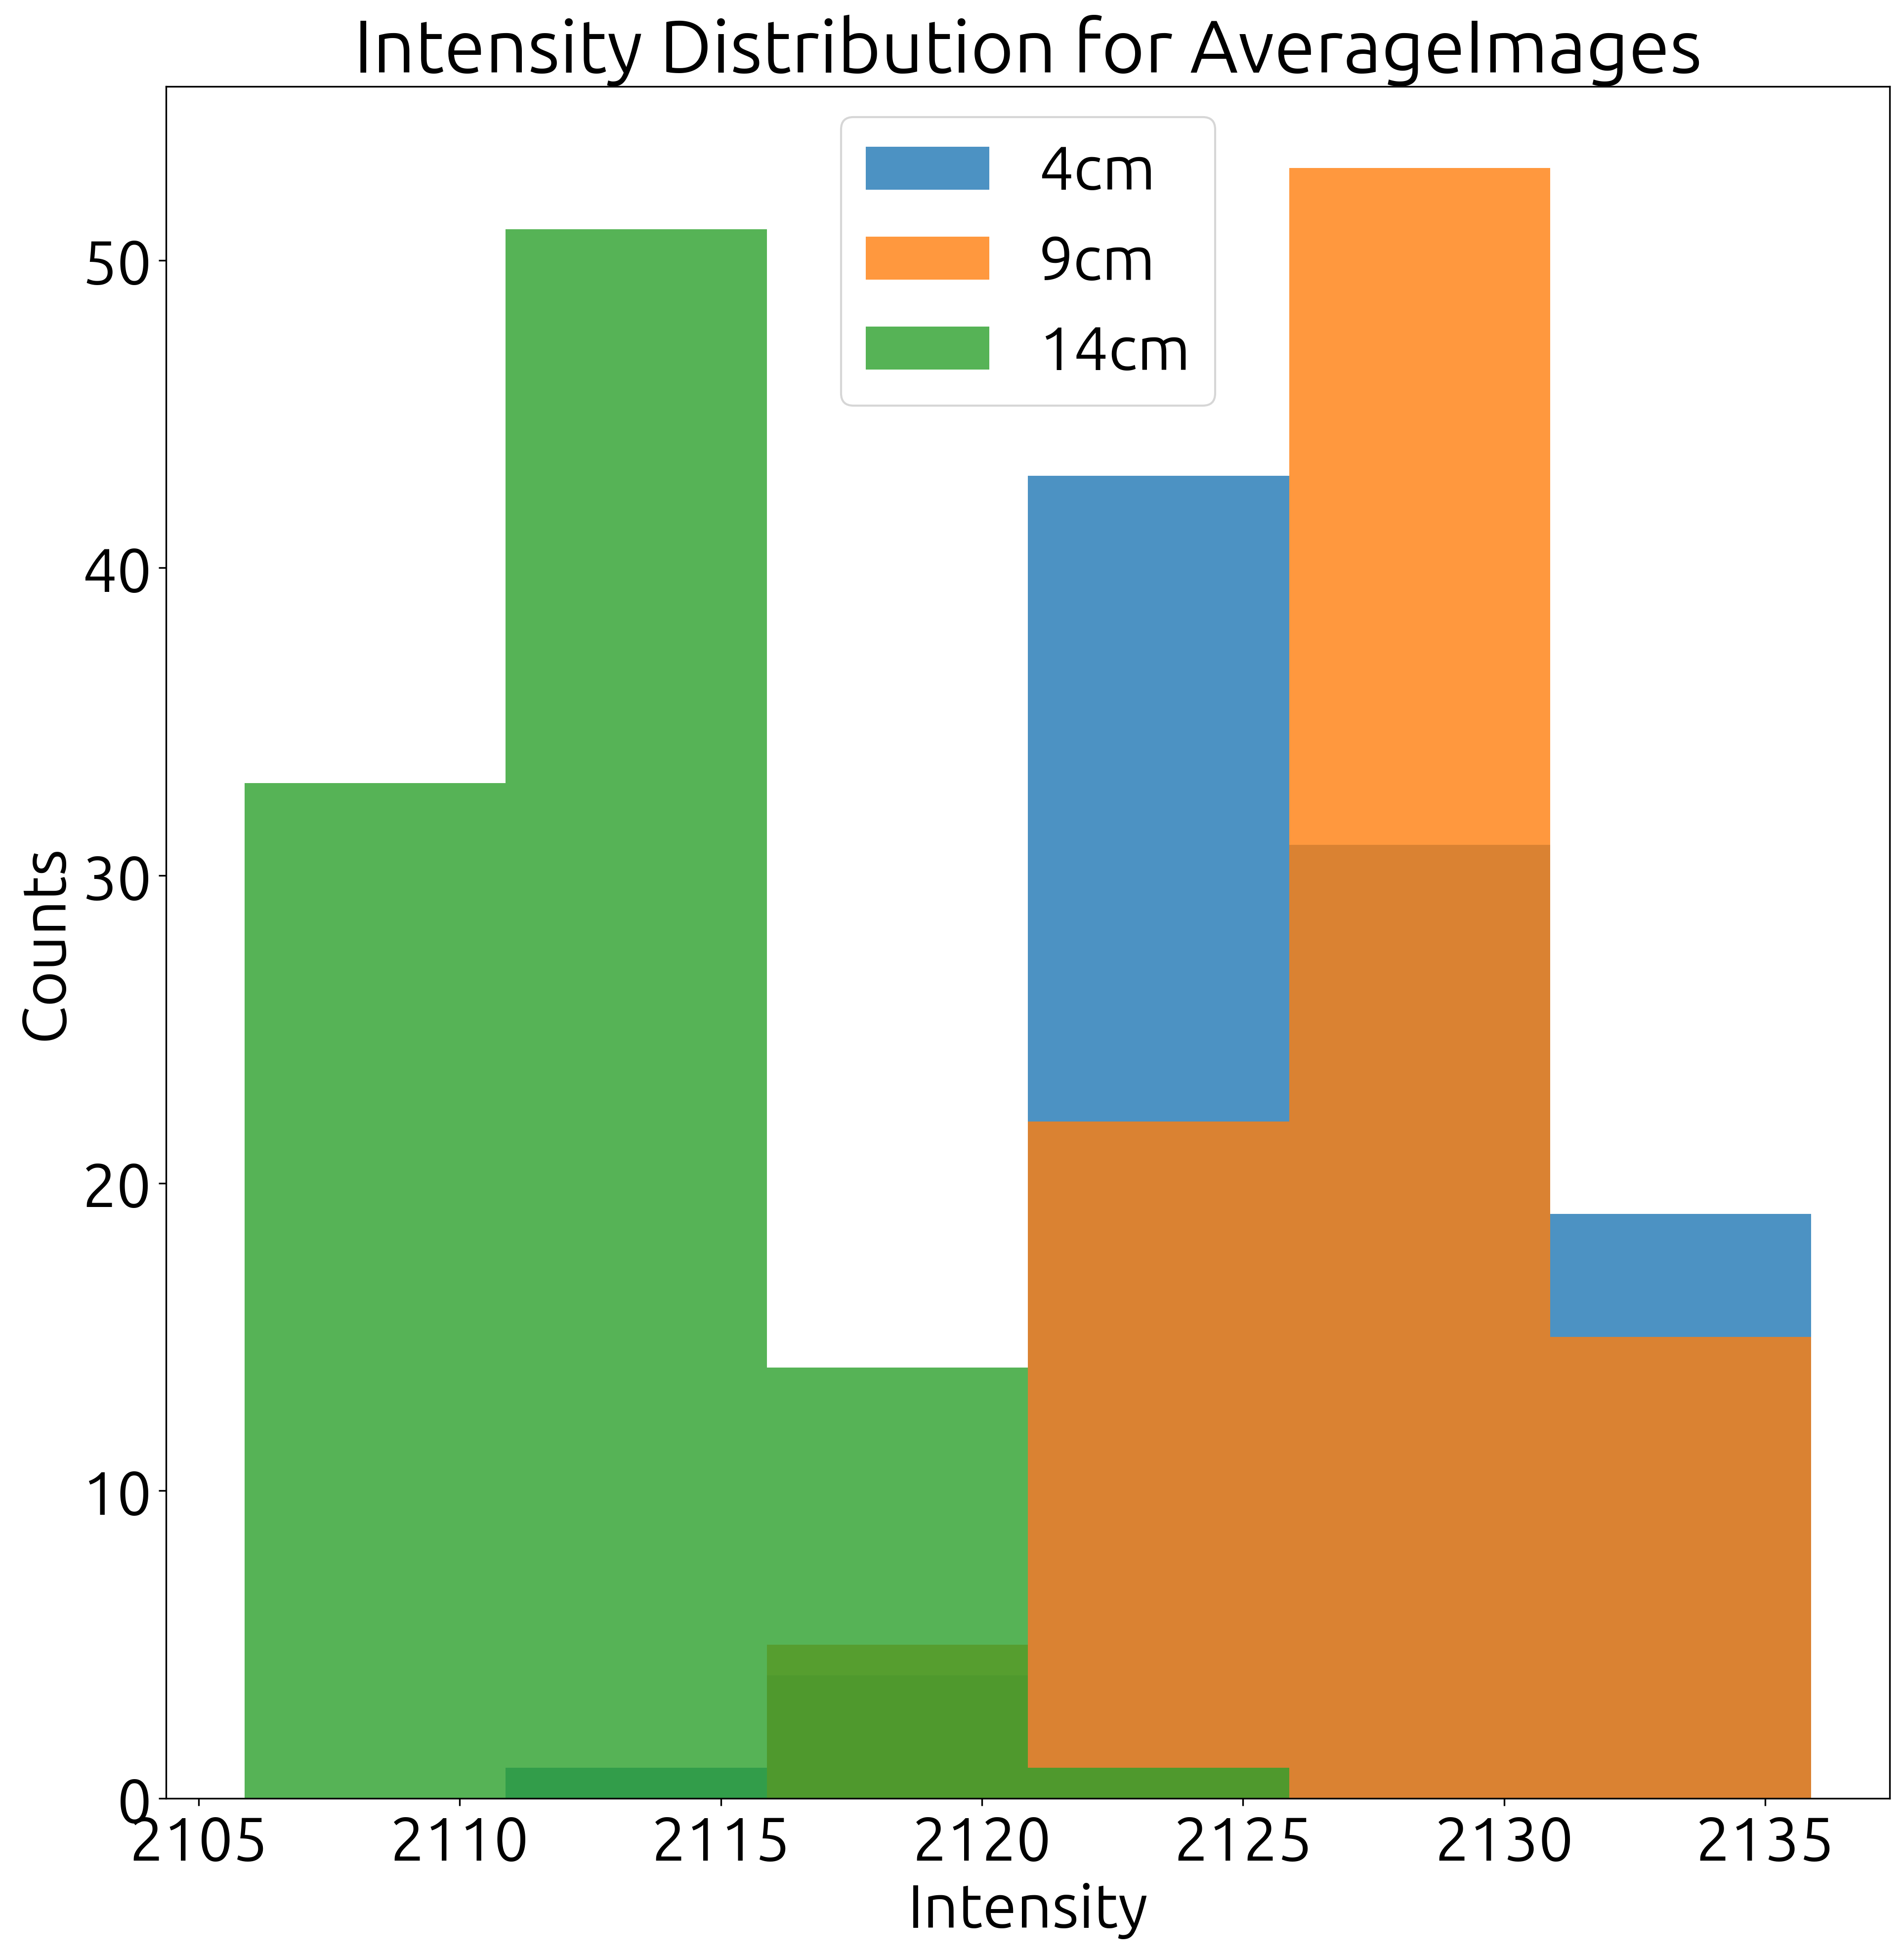

In [13]:
    
binss=np.arange(np.min(ValuesA["14cm"]),np.max(ValuesA["4cm"]),5)
plt.figure(figsize=(15,15),dpi=300)
plt.title("Intensity Distribution for AverageImages")
plt.hist(ValuesA["4cm"],label="4cm",bins=binss,alpha=0.8)
plt.hist(ValuesA["9cm"],label="9cm",bins=binss,alpha=0.8)
plt.hist(ValuesA["14cm"],label="14cm",bins=binss,alpha=0.8)
plt.xlabel("Intensity")
plt.ylabel("Counts")
plt.legend()
plt.show()
    

In [14]:
theAvrI=AvergImage(Images,200,Single=True)

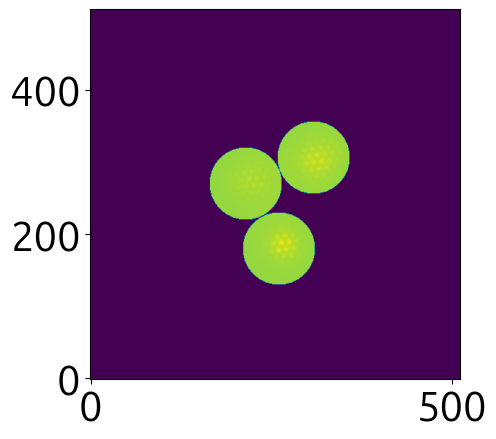

In [15]:
plt.imshow((theAvrI*Needle4cmMask[0])+(theAvrI*Needle9cmMask[0])+(theAvrI*Needle14cmMask[0]),origin="lower")

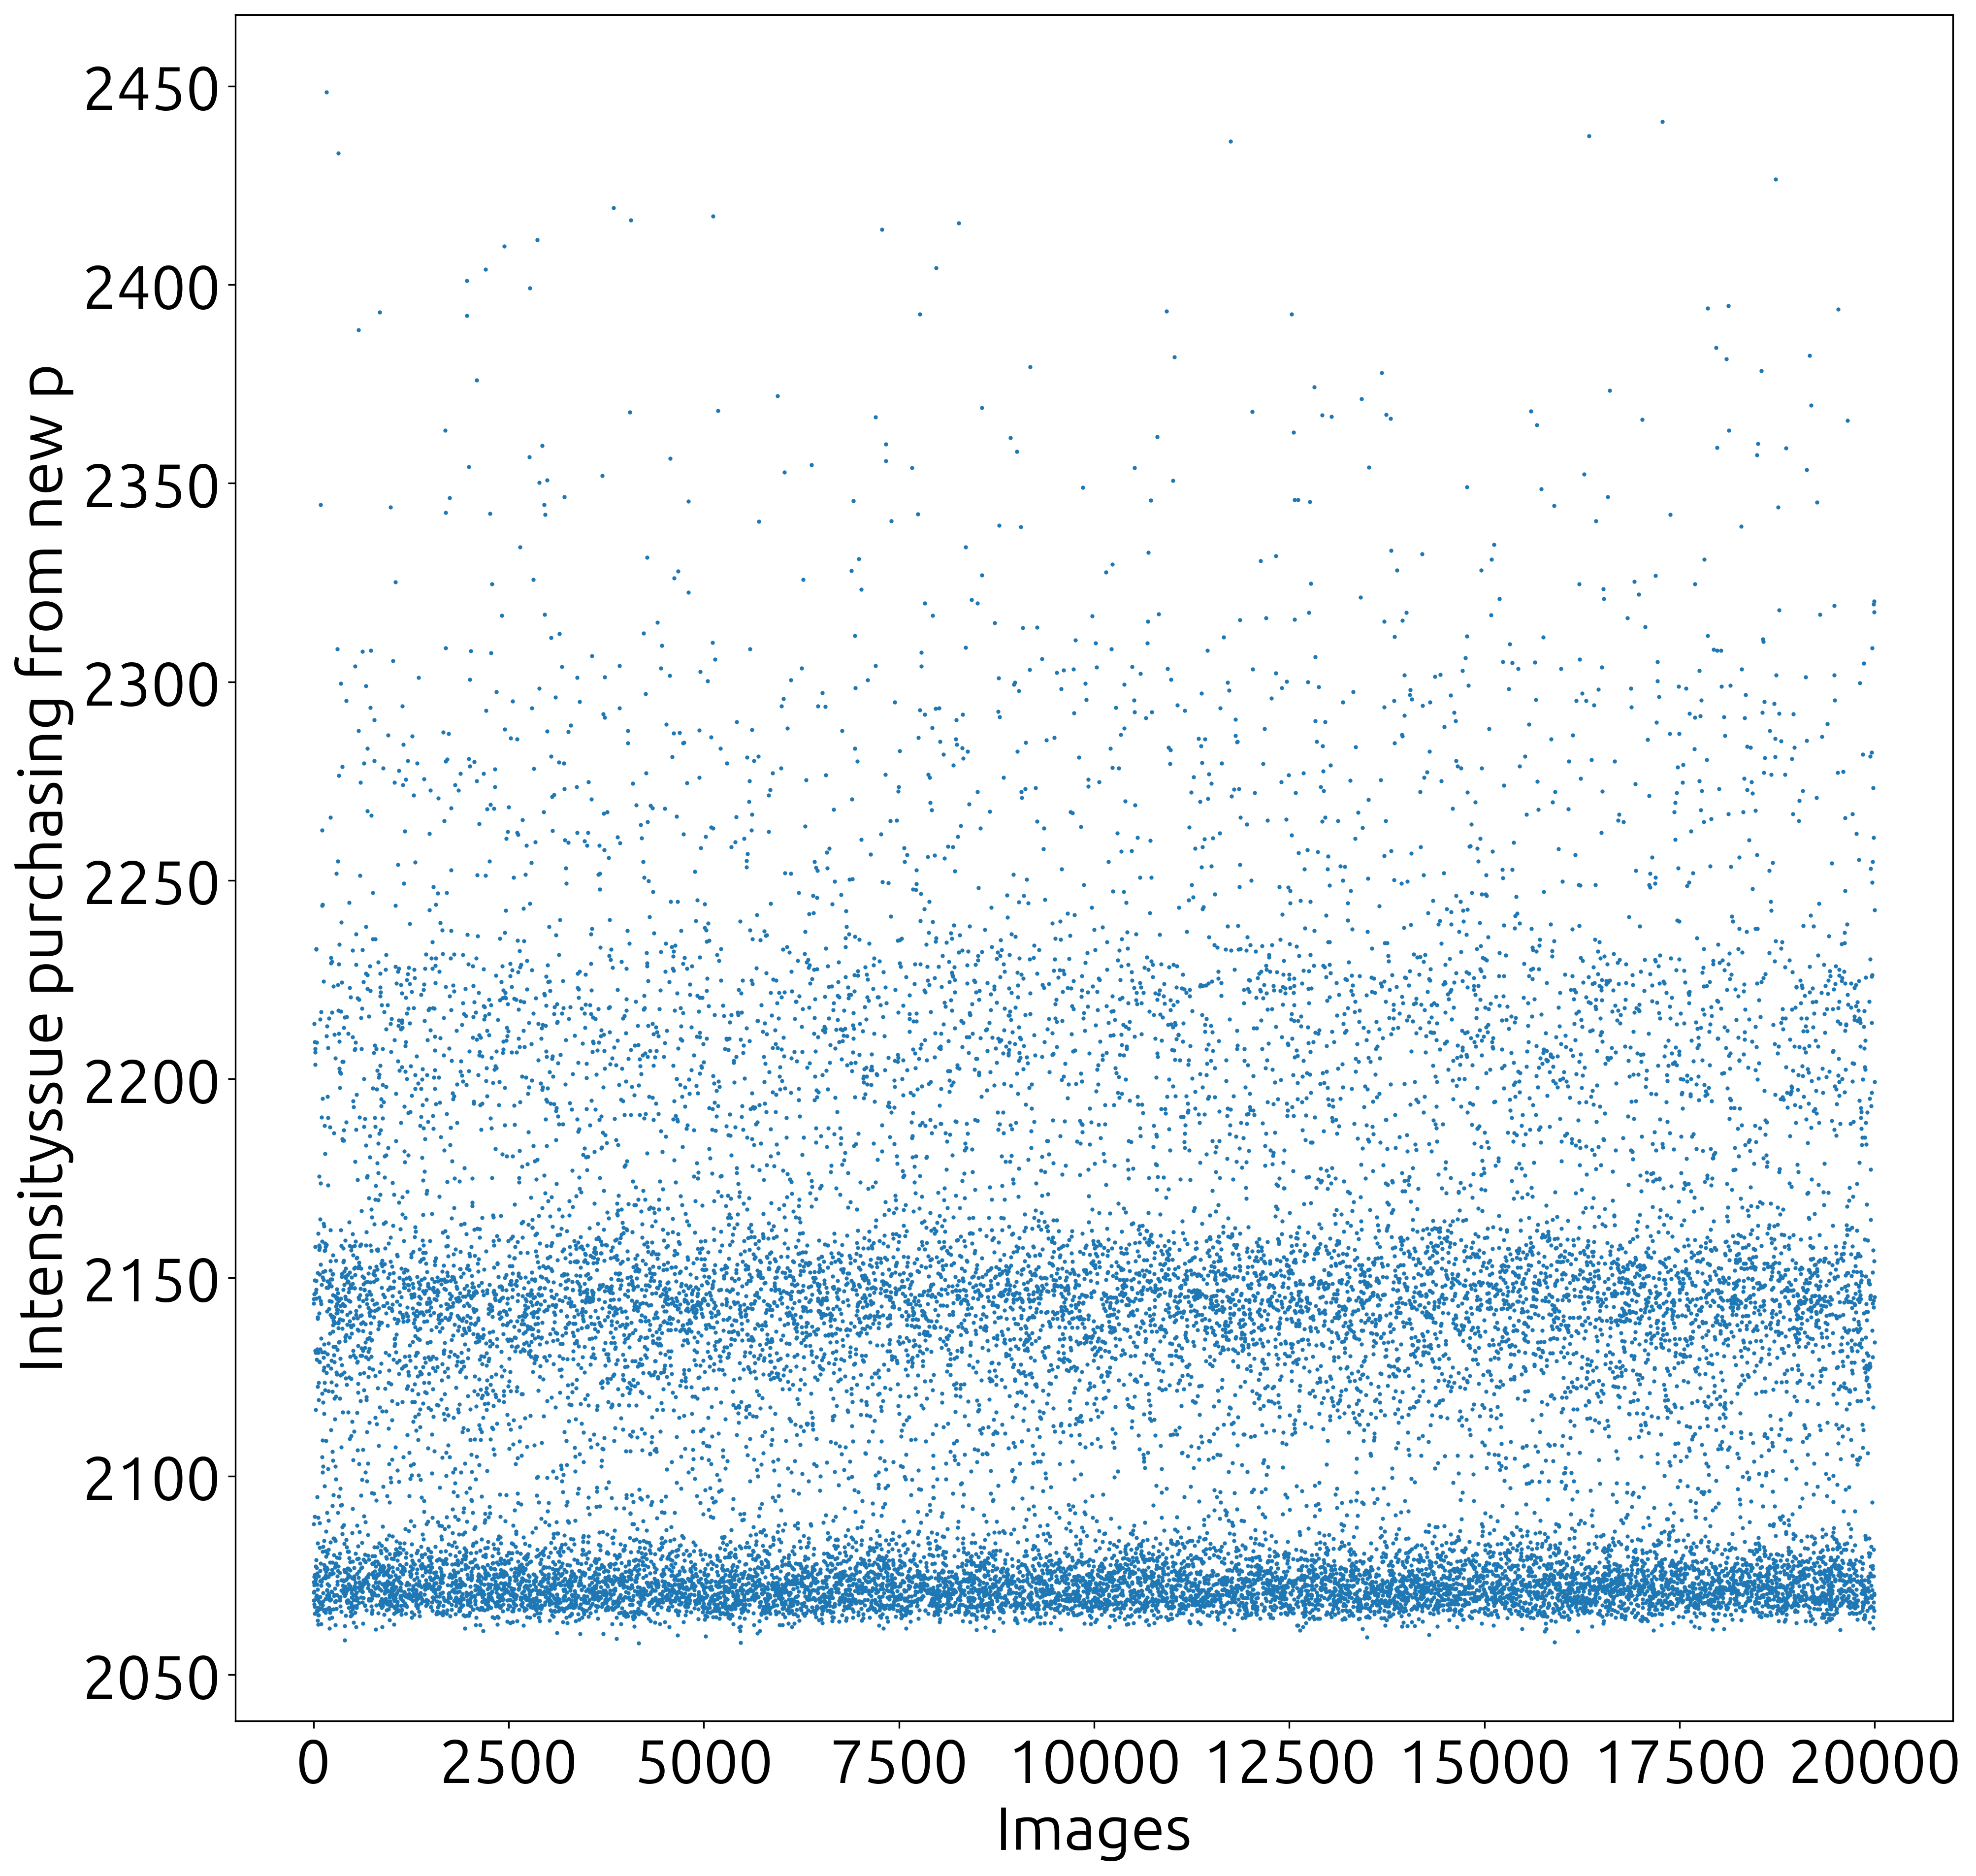

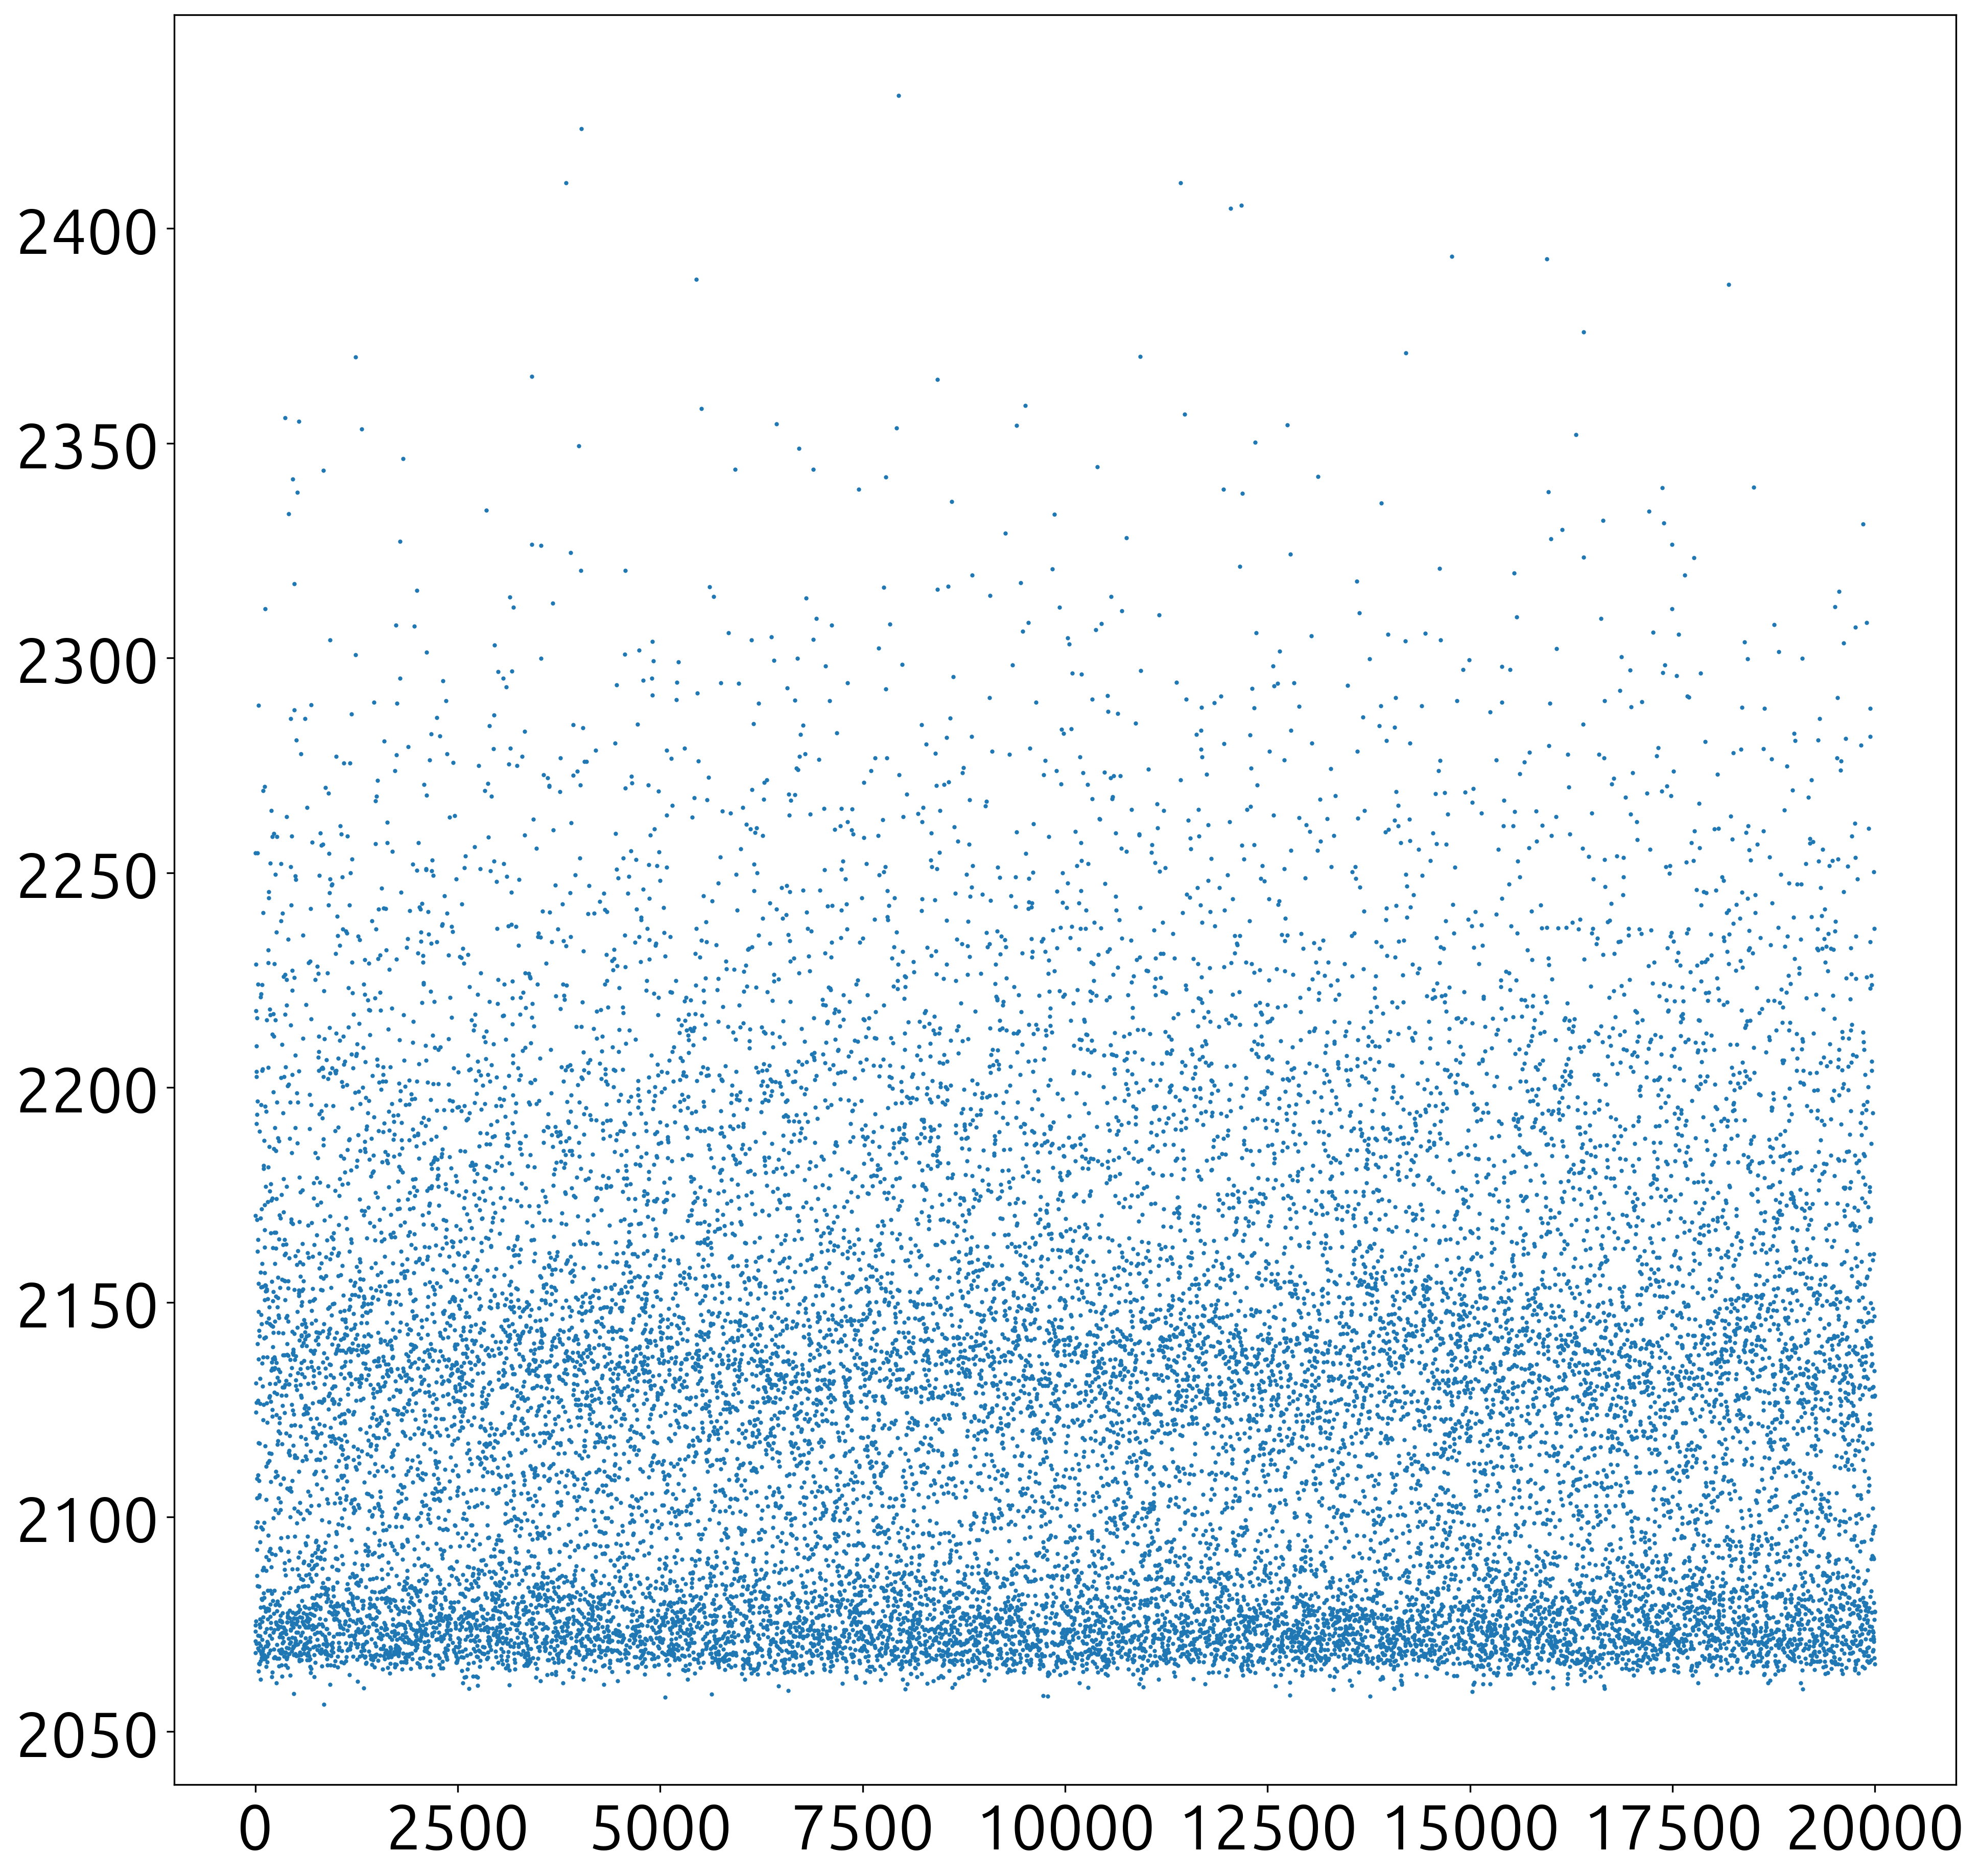

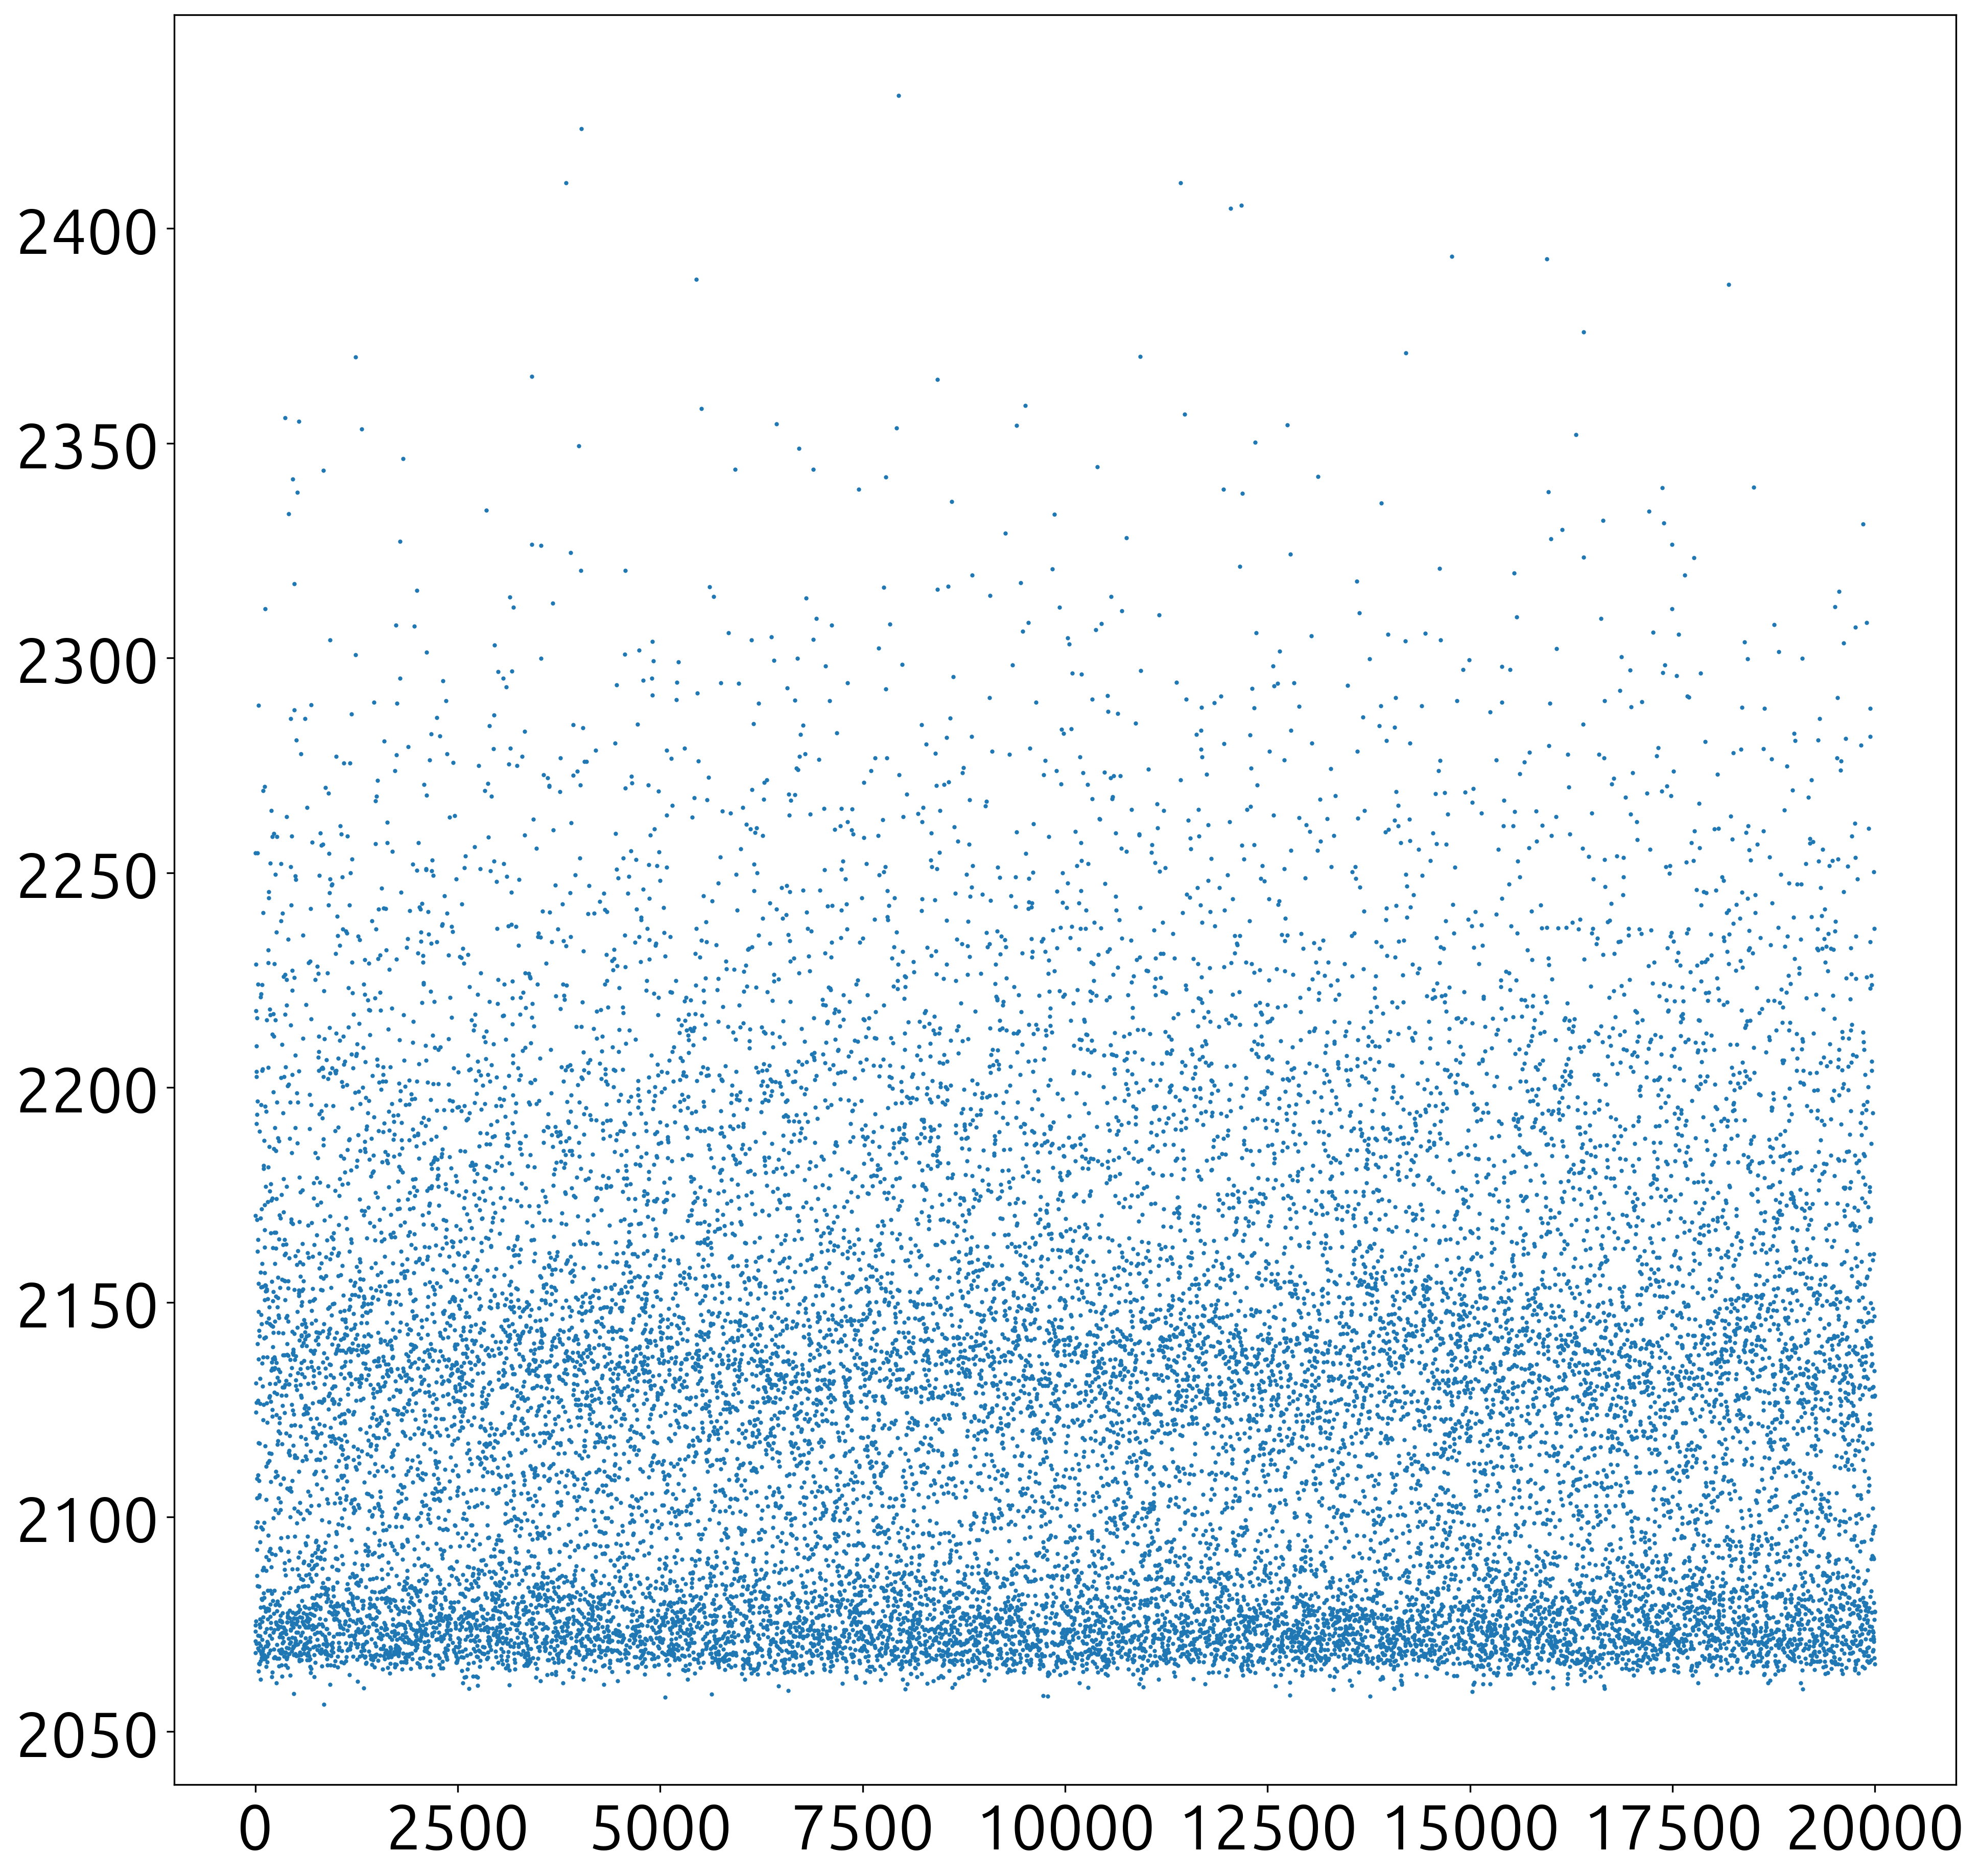

In [16]:
plt.figure(figsize=(15,15),dpi=300)
xx=np.arange(0,len(Values["4cm"]),1)

plt.scatter(xx,Values["4cm"],s=1,label="4cm")
plt.xlabel("Images")
plt.ylabel("Intensityssue purchasing from new p")
plt.show()
plt.figure(figsize=(15,15),dpi=300)
plt.scatter(xx,Values["9cm"],s=1,label="9cm")
plt.show()
plt.figure(figsize=(15,15),dpi=300)
plt.scatter(xx,Values["9cm"],s=1,label="9cm")
plt.show()




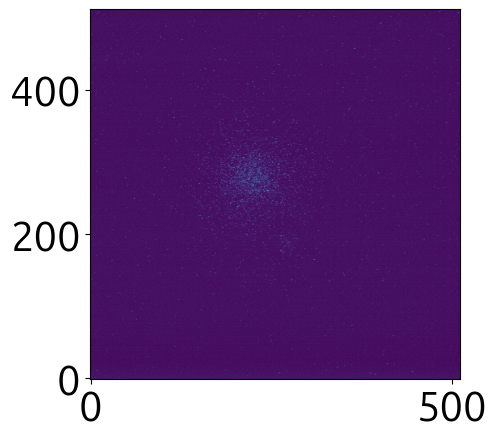

In [17]:
plt.imshow(Cut14cmImages[10],origin="lower")

In [65]:
Avg4cmImages=AvergImage(Cut4cmImages,100,Single=False)
Avg9cmImages=AvergImage(Cut9cmImages,100,Single=False)
Avg14cmImages=AvergImage(Cut14cmImages,100,Single=False)

In [66]:
print(len(Avg4cmImages))

36


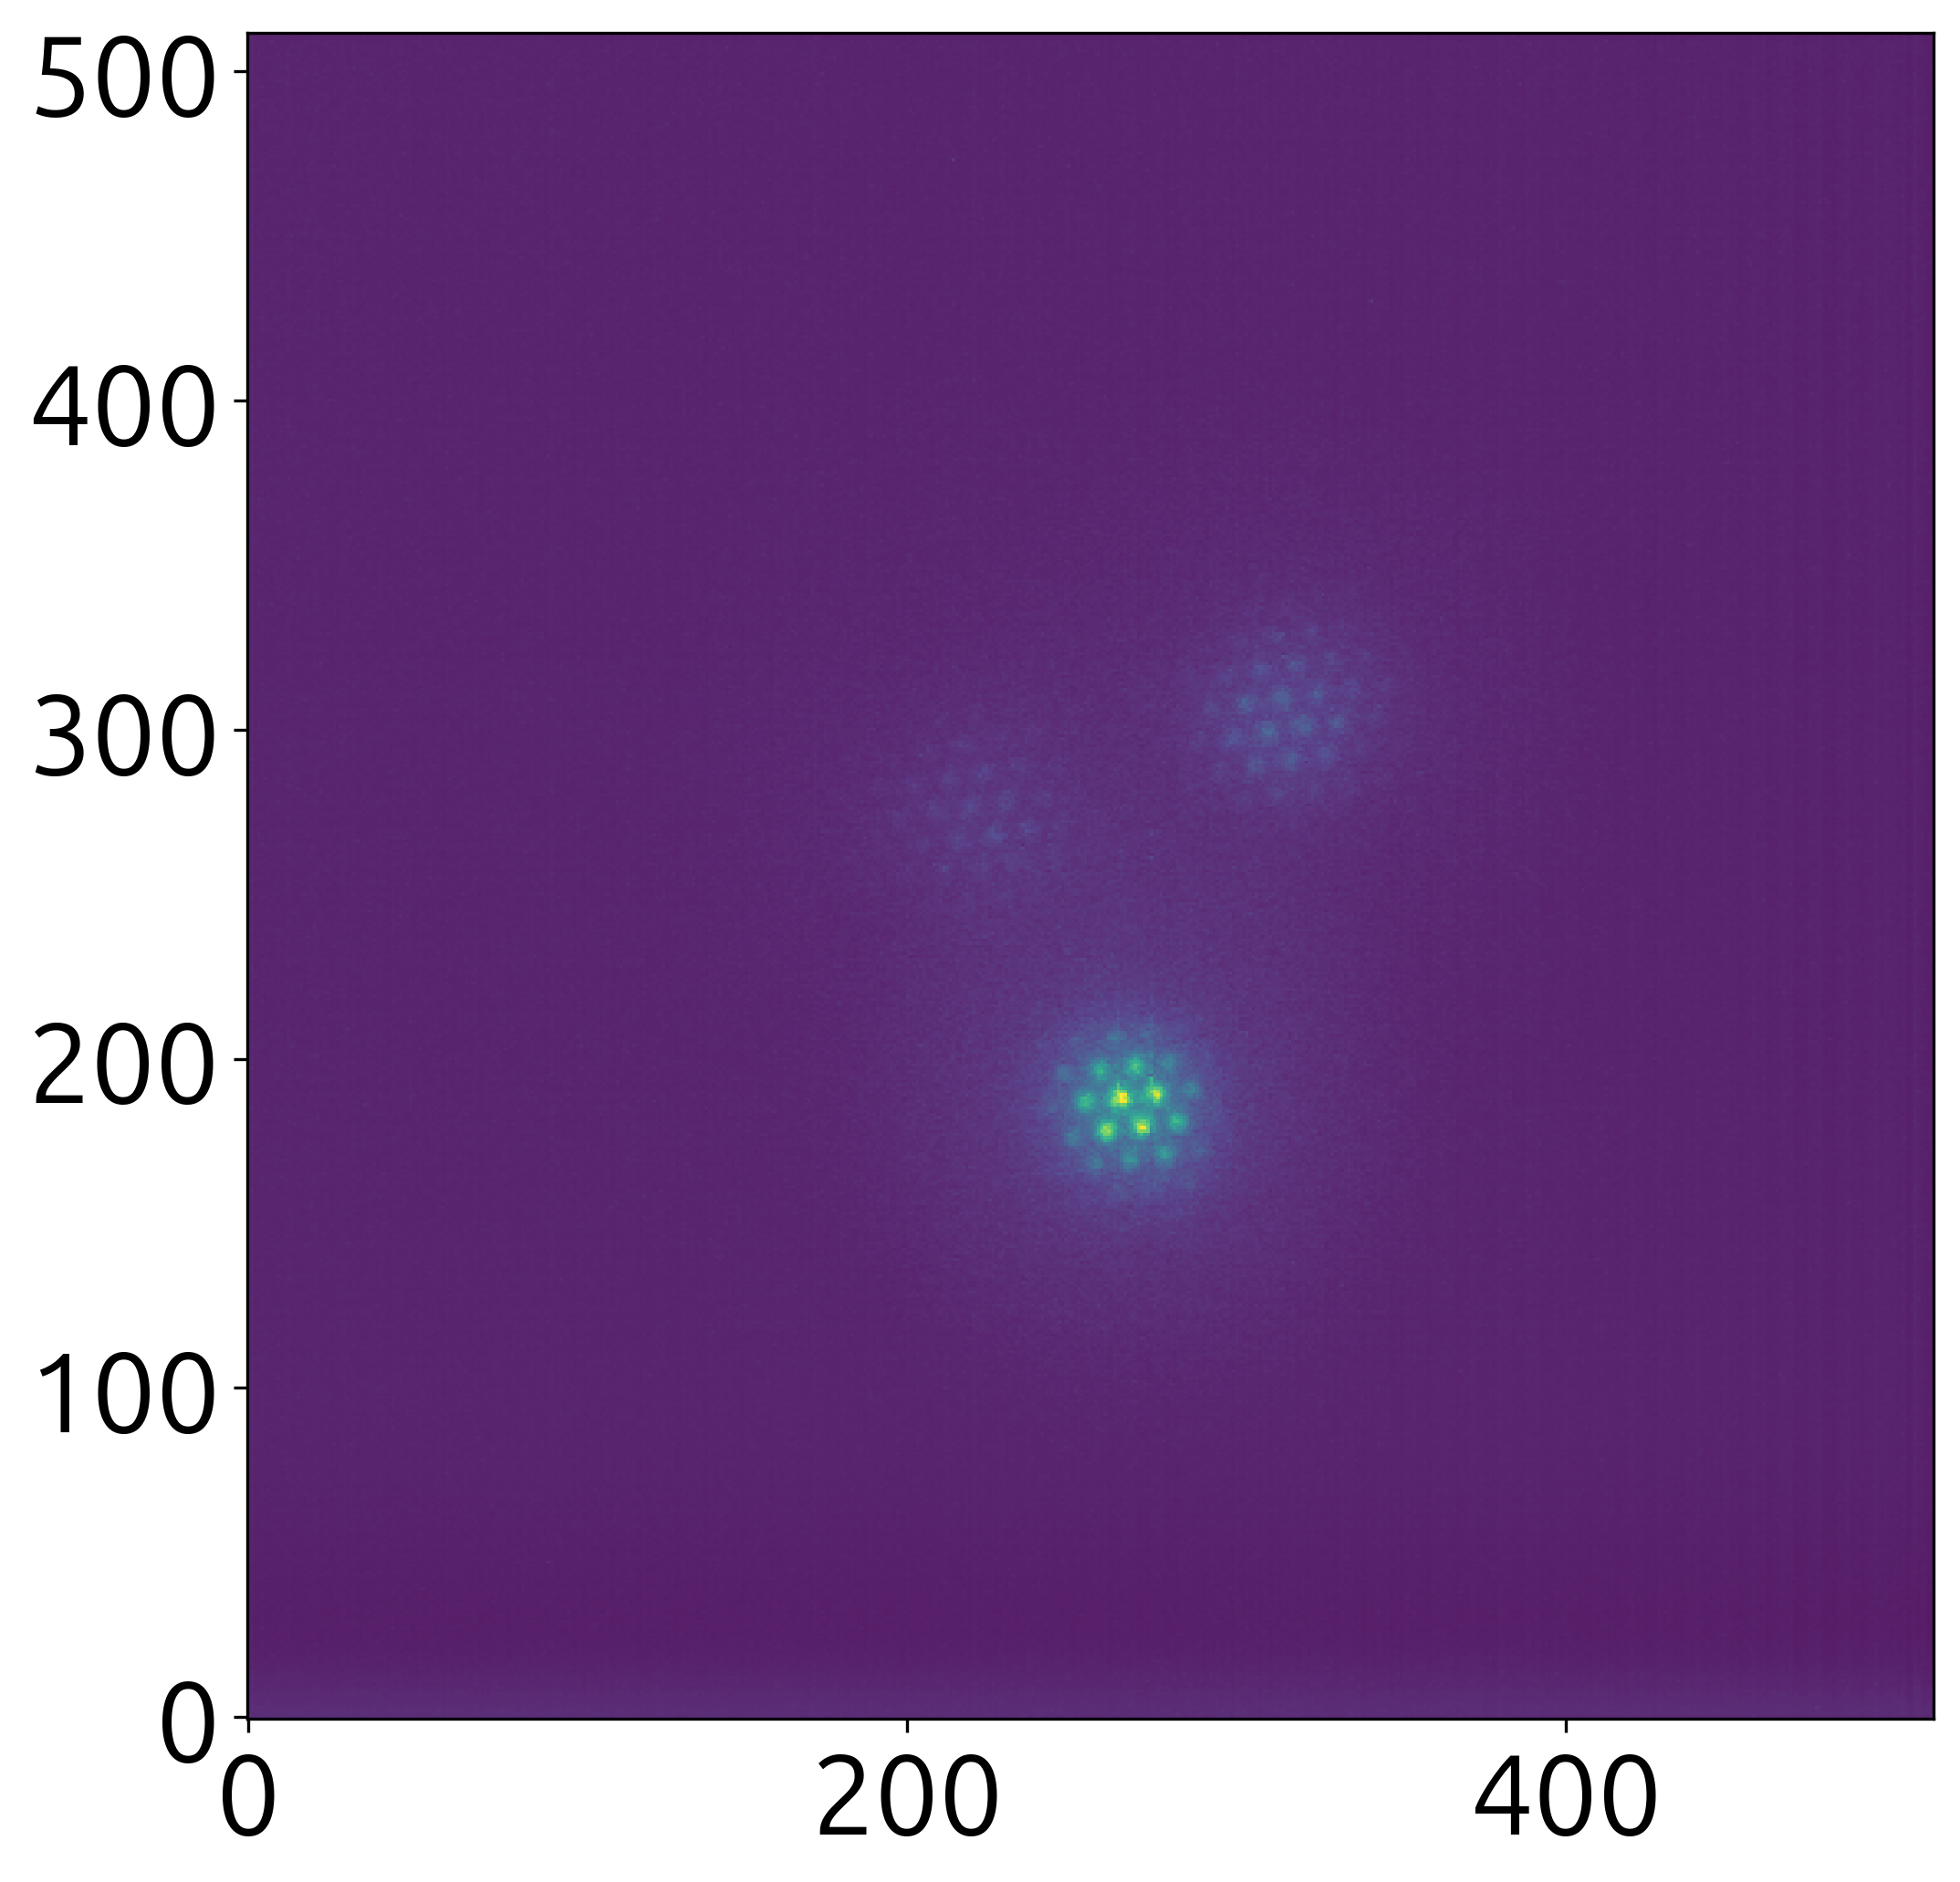

In [67]:
plt.figure(figsize=(8,8),dpi=300)
plt.imshow(Avg4cmImages[0],origin="lower",alpha=0.9)


In [33]:

def TwoDGaussian(xy,Amp,x0,sigmax,y0,sigmay=None,offset=1):
    x,y=xy
    if(sigmay==None):
        sigmay=sigmax
    value=Amp*np.exp(-((x-x0)**2/(2*sigmax**2)+(y-y0)**2/(2*sigmay**2)))+offset
    return value

In [42]:
offset=1
initialGuess_needle_4cm=np.mean(Avg4cmImages[0][Needle4cmMask[0]]), Needle4cmMask[2][0],18, Needle4cmMask[2][1],18
initialGuess_needle_9cm=np.mean(Avg9cmImages[0][Needle9cmMask[0]]), Needle9cmMask[2][0], 20, Needle9cmMask[2][1],20
initialGuess_needle_14cm=np.mean(Avg14cmImages[0][Needle14cmMask[0]]), Needle14cmMask[2][0], 25, Needle14cmMask[2][1],25


In [43]:
def Sumsof3Gaussian(xy,*initials):
    fit1=initials[0:5]
    fit2=initials[5:10]
    fit3=initials[10:15]
    offset=initials[-1:]
    Sum=TwoDGaussian(xy,*fit1)+TwoDGaussian(xy,*fit2)+TwoDGaussian(xy,*fit3)+offset
    return Sum.ravel()

def FitSumsof3Gaussian(img,fit1,fit2,fit3,offset,it=15000):
    x = np.linspace(0,img.shape[0],img.shape[0])
    xx, yy = np.meshgrid(x, x)
    flattened=img.ravel()
    popt, pcov = opt.curve_fit(Sumsof3Gaussian, (xx, yy),flattened , p0=(*fit1,*fit2,*fit3,offset),maxfev=it,method="dogbox")
    print(popt)
    data_fitted = Sumsof3Gaussian((xx, yy),*popt)
    return flattened.reshape(img.shape[0],img.shape[1]),data_fitted.reshape(img.shape[0],img.shape[1]),[xx,yy],popt



def FitGaussian(img,initials,offset,it=15000):
    x = np.linspace(0,img.shape[0],img.shape[0])
    xx, yy = np.meshgrid(x, x)
    flattened=img.ravel()
    print(initials)
    popt, pcov = opt.curve_fit(TwoDGaussian, (xx.ravel(), yy.ravel()),flattened ,p0=(*initials,offset),maxfev=it,method="dogbox")
    print(popt)
    data_fitted = TwoDGaussian((xx, yy),*popt)
    return flattened.reshape(img.shape[0],img.shape[1]),data_fitted.reshape(img.shape[0],img.shape[1]),[xx,yy],popt




In [55]:
Event=1
fit4=FitGaussian(Avg4cmImages[Event],initialGuess_needle_4cm,offset)
fit9=FitGaussian(Avg9cmImages[Event],initialGuess_needle_9cm,offset)
fit14=FitGaussian(Avg14cmImages[Event],initialGuess_needle_14cm,offset)

(2253.782385942492, 261, 18, 180, 18)
[ 596.29474716  268.45281275   17.69328933  185.76530029   18.03169456
 2065.59248985]
(2246.9112447284347, 309, 20, 306, 20)
[ 391.903824    315.22836999   23.85710684  304.31675688   23.36183583
 2064.77332054]
(2227.226844728434, 215, 25, 270, 25)
[ 309.54545429  224.02377505   27.48160729  275.09670687   26.92292802
 2064.2669337 ]


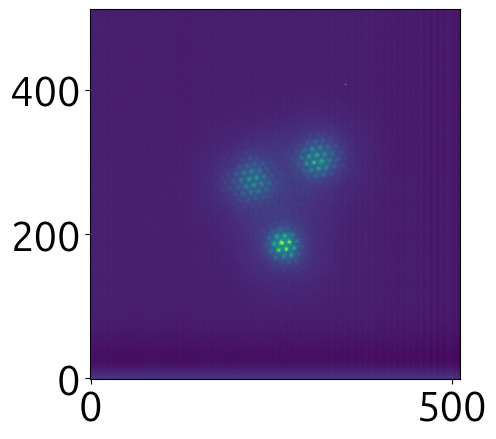

In [56]:
plt.imshow(Avg4cmImages[Event]+Avg9cmImages[Event]+Avg14cmImages[Event],origin="lower")

In [57]:
def ConvertToDiffusion(SigmaX,SigmaY,distance,pixelSize,Magnefication,DT=0.92):
    DTX=round((SigmaX/np.sqrt(distance))*pixelSize*Magnefication,2)
    DTY=round((SigmaY/np.sqrt(distance))*pixelSize*Magnefication,2)
    value=round((DTX+DTY)/2,2)
    Error=round(abs(DT-value)/DT,2)
    print(f"Needle Distance is {distance} cm")
    print(f"DT is {value} mm/sqrt(cm) error is {Error*100} %")
    
    
def GetTransVerseDiffusion(Fit,pixelSize,mag):
    
    DTX=Fit[2]*pixelSize
    DTY=Fit[4]*pixelSize
    DT=((DTX+DTY)/2)*mag
        
    #Error=round(abs(DT-value)/DT,2)
    return DT,Fit[2],Fit[4]    

In [58]:
Sig4=GetTransVerseDiffusion(fit4[3],0.016,15)
Sig9=GetTransVerseDiffusion(fit9[3],0.016,15)
Sig14=GetTransVerseDiffusion(fit14[3],0.016,15)
Sigs=np.array([Sig4[0],Sig9[0],Sig14[0]])
NeedleDistances=np.array([4.06,9.18,14.15])

In [59]:
print(Sigs)

[4.28699807 5.66627312 6.52854424]


Text(0.6, 0.5, 'y = 2.4x + 9.09 ')

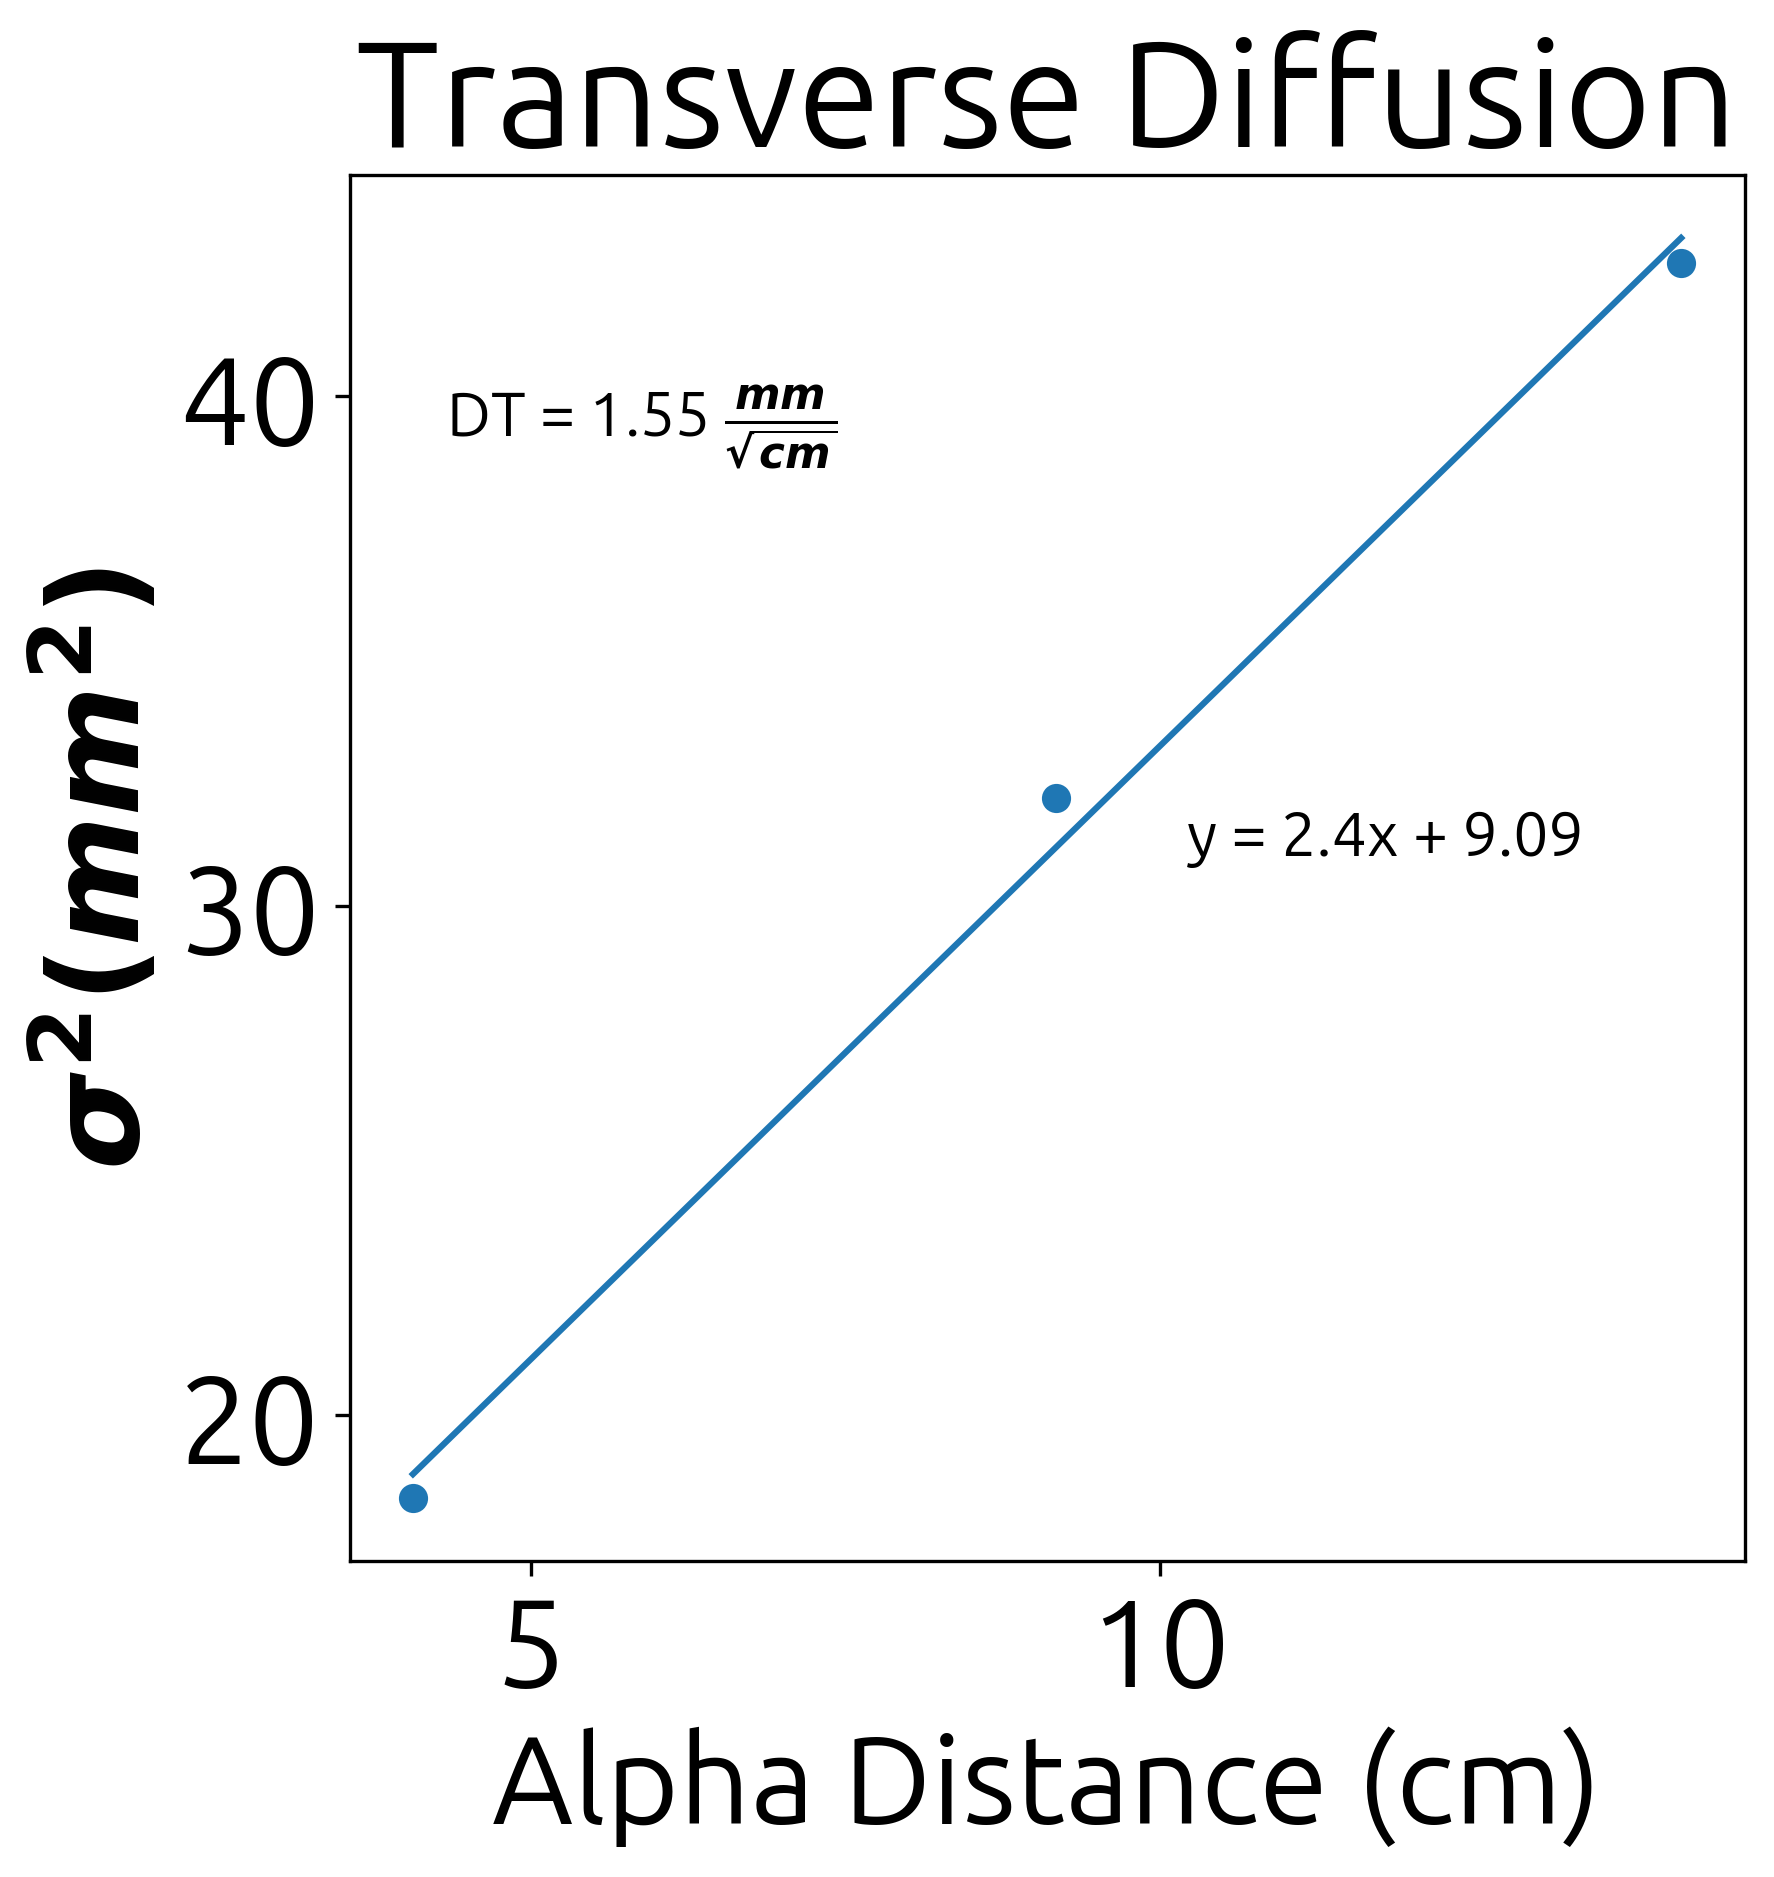

In [60]:
plt.figure(figsize=(6,6),dpi=300)
slope, intercept = np.polyfit(NeedleDistances, Sigs**2, 1)
plt.title("Transverse Diffusion")
plt.xlabel("Alpha Distance (cm)")
plt.ylabel(r'$\sigma^2 (mm^2)$')
plt.scatter(NeedleDistances,Sigs**2)
plt.plot(NeedleDistances,(slope*NeedleDistances+intercept))
DT=np.round(np.sqrt(slope),2)
plt.text(0.35,0.85,f"DT = {DT} " + r"$\frac{mm}{\sqrt{cm}}$",fontsize=15,horizontalalignment='right',verticalalignment='top',transform = plt.gca().transAxes)
#plt.text(5.8, 14, f"DT={D}" + r"$\frac{mm}{\sqrt{cm}}$", bbox=dict(facecolor='blue', alpha=0.5))
plt.text(0.6, 0.5,f"y = {round(slope,2)}x + {round(intercept,2)} ",fontsize=15,horizontalalignment='left',verticalalignment='bottom',transform = plt.gca().transAxes)
